##Modelo Predictivo de Prepagos Hipotecarios
# Baseline

El objetivo de esta sección es construir un modelo de referencia que permita evaluar la viabilidad del problema, determinando una solución mínima aceptable en términos de desempeño y predicción.

##Carga de información

Se cargan las librerías necesarias y el archivo con los datos ya preprocesados (ver avance de Ingeniería de Características).

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
from functools import partial

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Baseline/datos_preprocesados.xlsx"
df = pd.read_excel(file_path, sheet_name = "Datos")

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   pla_credit                             7381 non-null   int64  
 1   edad_cliente                           7381 non-null   float64
 2   score                                  7381 non-null   float64
 3   tasa                                   7381 non-null   float64
 4   plazo_original_meses                   7381 non-null   float64
 5   edad_credito                           7381 non-null   float64
 6   cantidad_prepago_ratio                 7381 non-null   float64
 7   prepago_total_ratio                    7381 non-null   float64
 8   enganche_ratio                         7381 non-null   float64
 9   cantidad_prepago_1                     7381 non-null   float64
 10  cantidad_prepago_2                     7381 non-null   float64
 11  cant

# Parte 1: Modelo de Clasificación

**- Variable objetivo:** 'prepago_dic' (1 = el cliente prepaga en diciembre 2024; 0 = no prepaga).

**- Tipo de modelo:** Clasificación supervisada.

**Selección del algoritmo**

La variable objetivo en la primera fase del modelo es "prepago_dic". Esta variable binaria indica si el cliente prepagó a diciembre 2024 (1) o no (0). Este problema, por tanto, es un problema de clasificación supervisada binaria.

Los modelos sugeridos para este tipo de problema son Regresión Logística, Random Forest, Gradient Boosting (como XGBoost), entre otros. Sin embargo, el elegido para utilizar como Baseline será **Regresión Logística** por las siguientes razones:



* **Interpretabilidad**: Permite analizar la influencia de cada variable sobre la probabilidad de prepago, lo cual es relevante para validar hipótesis de negocio (por ejemplo, que un mayor score crediticio aumente la probabilidad de prepago).
* **Probabilidad conitnua**: Genera una probabilidad continua entre 0 y 1, útil para establecer umbrales ajustables según el nivel de riesgo aceptado o para pruebas de sensibilidad.
* **Simplicidad y trazabilidad:** Es un modelo robusto y de bajo costo computacional, idóneo como baseline antes de avanzar hacia enfoques más complejos.


**Tratamiento de datos y balance de clases**

Los datos fueron previamente estructurados, transformados y escalados. Sin embargo, se identificó un desequilibrio en las clases (mayor proporción de clientes sin prepago). Para mitigar este sesgo y evitar un modelo sobreajustado, se aplicó una submuestra aleatoria (undersampling) de la clase mayoritaria, igualando el número de observaciones entre prepagos y no prepagos.

In [93]:
#primero hacemos el undersampling

df_0 = df[df["prepago_dic"] == 0]
df_1 = df[df["prepago_dic"] == 1]

df_0_sample = resample(df_0, replace=False, n_samples=len(df_1), random_state=0)

df_sample = pd.concat([df_1, df_0_sample])

In [94]:
#definimos las bases para X y y

#consideramos exclusiones del Avance 2
var_excluidas = ["pla_credit", "clasificacion","estado", "prepago_dic", "tasa", "estado_civil", "clasificacion_otros", "enganche_ratio", "edad_cliente", "region_Bajio-Occidente", "plazo_original_meses", "region_Noroeste", "region_Centro-Sur"]

var_x = [col for col in df_sample.columns if col not in var_excluidas]
var_y = "prepago_dic"

X = df_sample[var_x]
y = df_sample[var_y]

In [95]:
#definimos las bases de train y test para X y y, considerando que el prepago_dic esté balanceado en ambas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [96]:
# ajuste del modelo de regresión logística

model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

# predicciones

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

# métricas
def metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test):
    metricas_train = {
            "accuracy": accuracy_score(y_train, y_pred_train),
            "precision": precision_score(y_train, y_pred_train),
            "recall": recall_score(y_train, y_pred_train),
            "f1": f1_score(y_train, y_pred_train),
            "ROC_AUC": roc_auc_score(y_train, y_prob_train),
            "PR_AUC": average_precision_score(y_train, y_prob_train)
        }

    metricas_test = {
            "accuracy": accuracy_score(y_test, y_pred_test),
            "precision": precision_score(y_test, y_pred_test),
            "recall": recall_score(y_test, y_pred_test),
            "f1": f1_score(y_test, y_pred_test),
            "ROC_AUC": roc_auc_score(y_test, y_prob_test),
            "PR_AUC": average_precision_score(y_test, y_prob_test)
        }

    print("Métricas Train")
    for k,v in metricas_train.items(): print(f"{k}: {v:.2f}")
    print("\nMétricas Test")
    for k,v in metricas_test.items(): print(f"{k}: {v:.2f}")

    # gap para sub/sobreajuste
    print("\nSub/sobreajuste")
    for k in metricas_test.keys():
        gap = metricas_train[k] - metricas_test[k]
        print(f"{k:7s}  gap(train-test): {gap:+.2f}")

    # matriz de confusión
    print("\nMatriz de Confusión")
    print(confusion_matrix(y_test, y_pred_test))

    return metricas_train, metricas_test

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.74
precision: 0.83
recall: 0.61
f1: 0.71
ROC_AUC: 0.82
PR_AUC: 0.84

Métricas Test
accuracy: 0.73
precision: 0.78
recall: 0.63
f1: 0.70
ROC_AUC: 0.82
PR_AUC: 0.83

Sub/sobreajuste
accuracy  gap(train-test): +0.01
precision  gap(train-test): +0.05
recall   gap(train-test): -0.02
f1       gap(train-test): +0.00
ROC_AUC  gap(train-test): -0.01
PR_AUC   gap(train-test): +0.01

Matriz de Confusión
[[105  22]
 [ 46  80]]


**Resultados iniciales del modelo baseline**

Los resultados preliminares del modelo indican que la exactitud global es del 73%, lo que significa que el modelo predice correctamente aproximadamente siete de cada diez observaciones.

*   **La precisión (78%)** refleja la proporción de casos clasificados como prepago que efectivamente correspondieron a clientes que realizaron prepago.
*   **El recall (63%)** indica la proporción de clientes que realizaron prepago y fueron correctamente identificados por el modelo.
*   **El ROC_AUC (82%)** muestra la capacidad del modelo para distinguir entre clases; valores cercanos a 50% indicarían aleatoriedad, por lo que este resultado evidencia un desempeño aceptable.
*   **La métrica PR_AUC (83%)**, enfocada en la clase positiva, refuerza que el modelo presenta una buena capacidad para detectar casos de prepago.

En conjunto, los resultados sugieren que el modelo tiene una buena precisión, pero aún no detecta una parte significativa de los casos positivos, evidenciando oportunidades de mejora.

Comenzaremos identificando características importantes para evaluar si se pueden reducir el número de variables utilizadas y eliminar a las que generan ruido o tienen mucha colinealidad.

## Características importantes

En esta sección se realiza un análisis de relevancia de características, para evaluar si mejora el modelo reduciendo la dimensionalidad y eliminando variables correlacionadas.

### Con penalización en Regresión Logística

Primero observamos los coeficientes del modelo original, para evaluar si existen algunos cercanos a cero que puedan eliminarse con un método de penalización.

Text(0.5, 1.0, 'Coeficientes de Regresión Logística')

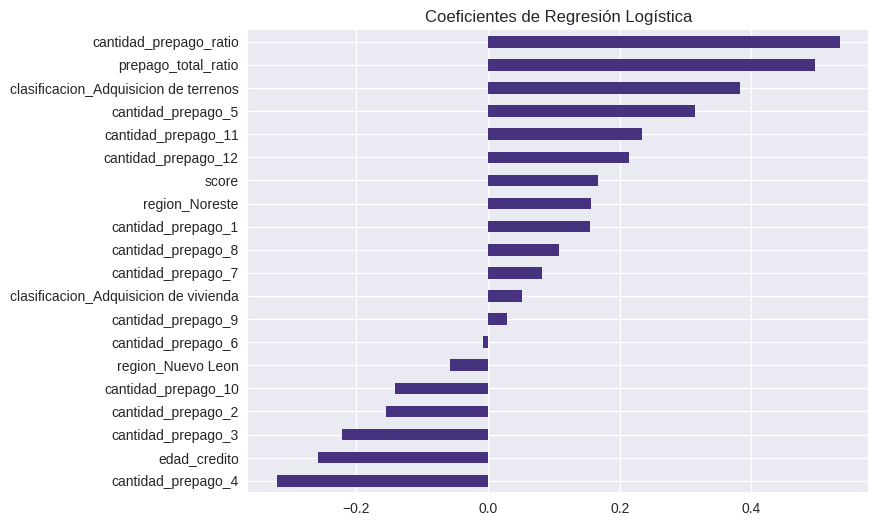

In [97]:
# extraer coeficientes del modelo
coefs = pd.Series(model.coef_[0], index=X_train.columns)

plt.figure(figsize=(8,6))
coefs.sort_values().plot(kind="barh")
plt.title(f"Coeficientes de Regresión Logística")

Agregaremos una penalización Lasso para obligar a que varios coeficientes sean exactamente 0 y así eliminar a las variables menos importantes. Probamos con diferentes valores para el parámetro "C" que entre menor sea indica una regularización mayor.

Text(0.5, 1.0, 'Coeficientes de Regresión Logística')

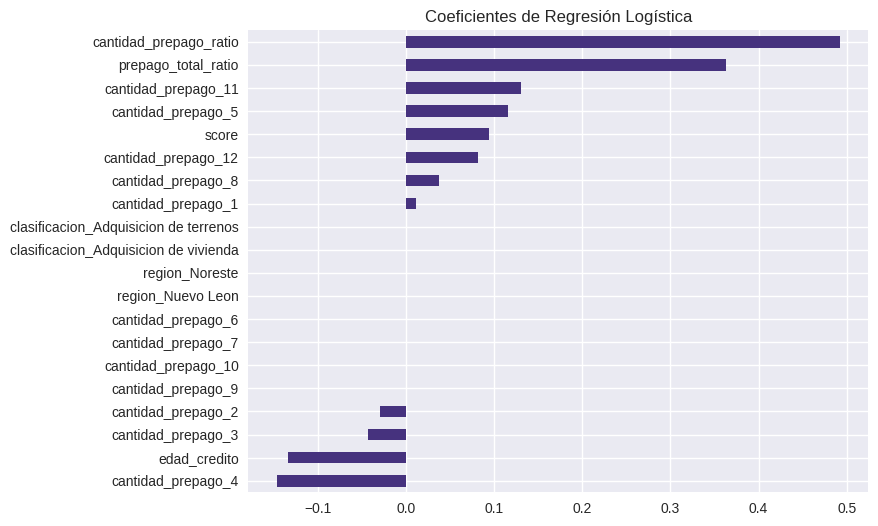

In [98]:
# ajuste del modelo de regresión logística

model = LogisticRegression(penalty= "l1", solver = 'saga', C = 0.1 ,random_state=0, max_iter = 5000)
model.fit(X_train, y_train)

# predicciones

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

# extraer coeficientes del modelo
coefs = pd.Series(model.coef_[0], index=X_train.columns)

plt.figure(figsize=(8,6))
coefs.sort_values().plot(kind="barh")
plt.title(f"Coeficientes de Regresión Logística")

In [99]:
# métricas

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.74
precision: 0.82
recall: 0.61
f1: 0.70
ROC_AUC: 0.81
PR_AUC: 0.83

Métricas Test
accuracy: 0.73
precision: 0.79
recall: 0.63
f1: 0.70
ROC_AUC: 0.82
PR_AUC: 0.84

Sub/sobreajuste
accuracy  gap(train-test): +0.00
precision  gap(train-test): +0.03
recall   gap(train-test): -0.02
f1       gap(train-test): -0.00
ROC_AUC  gap(train-test): -0.02
PR_AUC   gap(train-test): -0.01

Matriz de Confusión
[[106  21]
 [ 47  79]]


### RFECV

Ahora probaremos Recursive Feature Elimination with Cross-Validation (método _wrapper_). Este método ajusta el modelo eliminando una por una las variables menos relevantes por tamaño del coeficiente. En cada ajuste prueba con 5 grupo aleatorios de los datos (para incluir validación cruzada), y calcula el Recall promedio. Utilizamos el Recall porque por la naturaleza del proyecto, el costo de los Falsos Negativos es mayor al costo de los Falsos Positivos, es decir, lo que más interesa es minimizar la cantidad de positivos reales que pasan indetectados por el modelo.


RFECV: número óptimo de características: 3


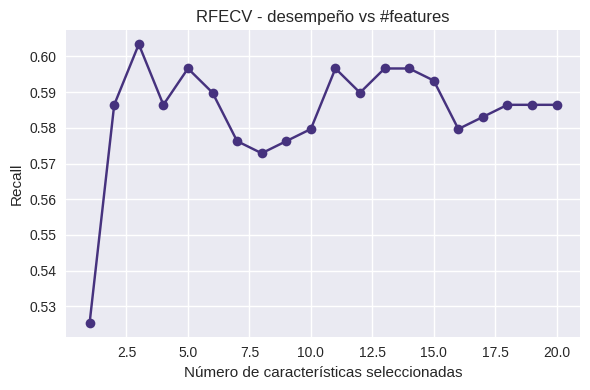

In [100]:
# dividimos los datos en 5 grupos para validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
estimator = LogisticRegression(random_state=0)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring="recall",
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

print(f"\nRFECV: número óptimo de características: {rfecv.n_features_}")
plt.figure(figsize=(6,4))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1),
         rfecv.cv_results_['mean_test_score'], marker="o")
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Recall")
plt.title("RFECV - desempeño vs #features")
plt.tight_layout()
plt.show()

La gráfica anterior muestra que con únicamente 3 variables es posible optimizar el Recall, ahora ajustaremos el modelo con únicamnete esas 3 variables seleccionadas.

In [101]:
X_seleccionadas = rfecv.support_
X_train_seleccionadas = X_train.loc[:, X_seleccionadas]
X_test_seleccionadas = X_test.loc[:, X_seleccionadas]

model = LogisticRegression(random_state=0)
model.fit(X_train_seleccionadas, y_train)

y_pred_train = model.predict(X_train_seleccionadas)
y_pred_test = model.predict(X_test_seleccionadas)

y_prob_train = model.predict_proba(X_train_seleccionadas)[:, 1]
y_prob_test = model.predict_proba(X_test_seleccionadas)[:, 1]

# métricas

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.73
precision: 0.81
recall: 0.60
f1: 0.69
ROC_AUC: 0.79
PR_AUC: 0.79

Métricas Test
accuracy: 0.75
precision: 0.82
recall: 0.65
f1: 0.73
ROC_AUC: 0.81
PR_AUC: 0.82

Sub/sobreajuste
accuracy  gap(train-test): -0.02
precision  gap(train-test): -0.01
recall   gap(train-test): -0.05
f1       gap(train-test): -0.03
ROC_AUC  gap(train-test): -0.02
PR_AUC   gap(train-test): -0.03

Matriz de Confusión
[[109  18]
 [ 44  82]]


Text(0.5, 1.0, 'Coeficientes de Regresión Logística')

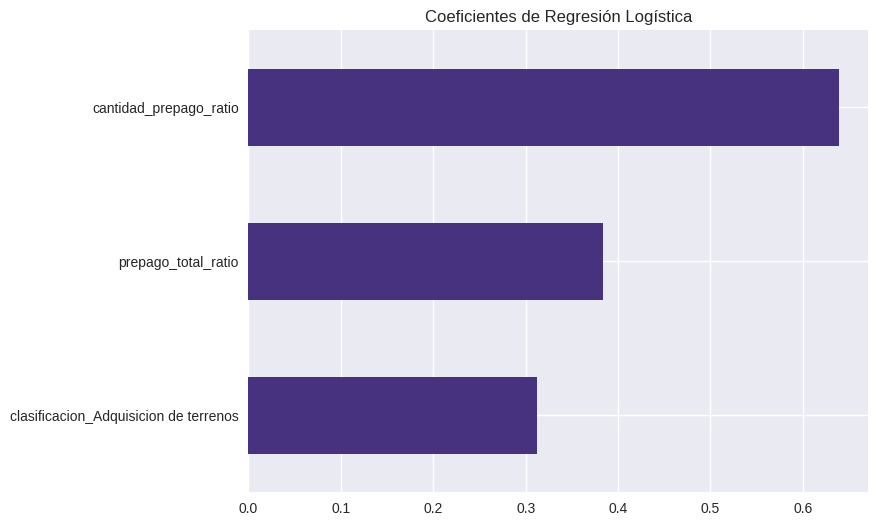

In [102]:
# extraer coeficientes del modelo
coefs = pd.Series(model.coef_[0], index=X_train_seleccionadas.columns)

plt.figure(figsize=(8,6))
coefs.sort_values().plot(kind="barh")
plt.title(f"Coeficientes de Regresión Logística")

### PCA

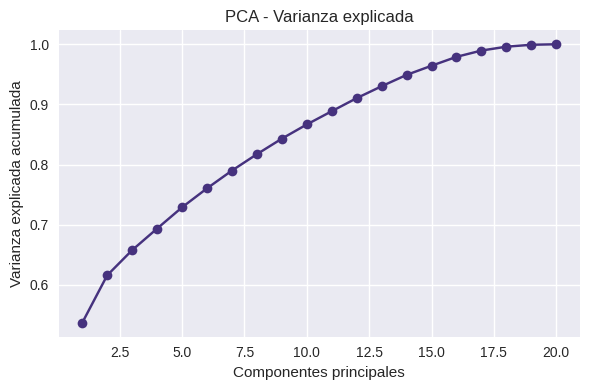

In [103]:
pca = PCA(n_components=20, random_state=0)
pca.fit(X_train, y_train)
expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, 21), np.cumsum(expl_var), marker="o")
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada")
plt.tight_layout()
plt.show()

In [104]:
varianza_acum = np.cumsum(expl_var)
n_componentes_90 = np.argmax(varianza_acum >= 0.90) + 1
print(f"Componentes necesarios para explicar el 90%: {n_componentes_90}")

Componentes necesarios para explicar el 90%: 12


In [105]:
# PCA + modelo
pca_logit = Pipeline(steps=[
    ('pca', PCA(n_components=n_componentes_90, random_state=0)),
    ('logit', LogisticRegression(random_state=0))
])

pca_logit.fit(X_train, y_train)

y_pred_train = pca_logit.predict(X_train)
y_prob_train = pca_logit.predict_proba(X_train)[:,1]

y_pred_test = pca_logit.predict(X_test)
y_prob_test = pca_logit.predict_proba(X_test)[:,1]


# métricas

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.74
precision: 0.82
recall: 0.61
f1: 0.70
ROC_AUC: 0.81
PR_AUC: 0.83

Métricas Test
accuracy: 0.74
precision: 0.81
recall: 0.62
f1: 0.70
ROC_AUC: 0.81
PR_AUC: 0.83

Sub/sobreajuste
accuracy  gap(train-test): -0.00
precision  gap(train-test): +0.01
recall   gap(train-test): -0.01
f1       gap(train-test): -0.00
ROC_AUC  gap(train-test): -0.00
PR_AUC   gap(train-test): +0.01

Matriz de Confusión
[[109  18]
 [ 48  78]]


### Información Mutua (MI)

Ahora se probará puntuar todas las varaibles con la Información Mutua, para quedarnos con las puntuaciones mayores a cero.

Este indicador calcula cuánta información aporta cada variable para predecir y, detectando también relaciones no lineales.

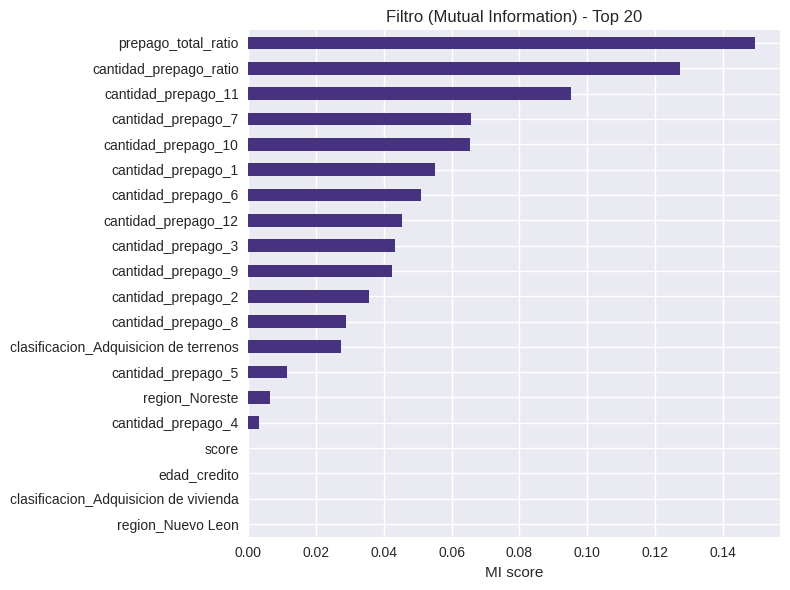

In [106]:
K = 20

mi_func = partial(mutual_info_classif, random_state=0, n_neighbors=3, discrete_features='auto')
mi_selector = SelectKBest(score_func=mi_func, k=K)
mi_selector.fit(X_train, y_train)

# Recuperar puntajes de MI con nombres de columnas originales
mi_scores = pd.Series(mi_selector.scores_, index=X_train.columns)
mi_scores.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8,6))
mi_scores.sort_values().plot(kind="barh")
plt.title(f"Filtro (Mutual Information) - Top {len(mi_scores)}")
plt.xlabel("MI score")
plt.tight_layout()
plt.show()

In [107]:
K = 16

topk_cols = mi_scores.index[:K]
X_train_topk = X_train[topk_cols]
X_test_topk = X_test[topk_cols]

model = LogisticRegression(class_weight='balanced', random_state=0, max_iter=1000)
model.fit(X_train_topk, y_train)

y_pred_train = model.predict(X_train_topk)
y_pred_test = model.predict(X_test_topk)

y_prob_train = model.predict_proba(X_train_topk)[:, 1]
y_prob_test = model.predict_proba(X_test_topk)[:, 1]

# métricas

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.74
precision: 0.82
recall: 0.61
f1: 0.70
ROC_AUC: 0.80
PR_AUC: 0.82

Métricas Test
accuracy: 0.76
precision: 0.82
recall: 0.66
f1: 0.73
ROC_AUC: 0.82
PR_AUC: 0.82

Sub/sobreajuste
accuracy  gap(train-test): -0.02
precision  gap(train-test): -0.01
recall   gap(train-test): -0.05
f1       gap(train-test): -0.03
ROC_AUC  gap(train-test): -0.02
PR_AUC   gap(train-test): +0.00

Matriz de Confusión
[[109  18]
 [ 43  83]]


## Sub / sobreajuste

Con el modelo seleccionado mediante RFECV, que utiliza únicamente 3 variables, por ser el más simple y que mantiene en general los resultados de accuracy y recall comparado con los otros modelos, se compararán el recall de acuerdo al tamaño de entrenamiento, y tomando en cuenta la validación cruzada (cv), para concluir si hay sub/sobreajuste.

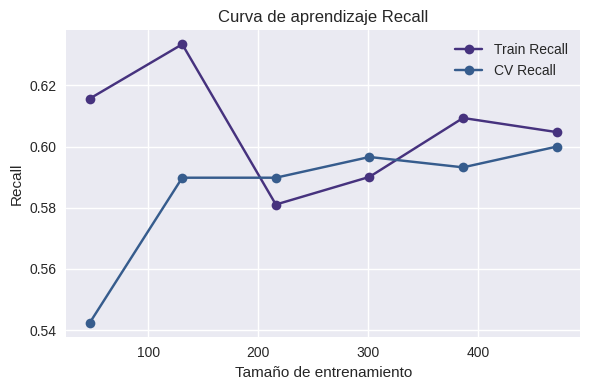

In [108]:
model = LogisticRegression(random_state=0)
model.fit(X_train_seleccionadas, y_train)

y_pred_train = model.predict(X_train_seleccionadas)
y_pred_test = model.predict(X_test_seleccionadas)

y_prob_train = model.predict_proba(X_train_seleccionadas)[:, 1]
y_prob_test = model.predict_proba(X_test_seleccionadas)[:, 1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_seleccionadas, y_train, cv=cv, scoring="recall",
    train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=-1, shuffle=True, random_state=0)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train Recall")
plt.plot(train_sizes, test_scores.mean(axis=1),  marker="o", label="CV Recall")
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Recall")
plt.title("Curva de aprendizaje Recall")
plt.legend()
plt.tight_layout()
plt.show()

La gráfica anterior indica que el modelo generaliza bien los resultados. Comenzando con una brecha importante entre el recall de entrenamiento y el prueba, por un tamaño pequeño de entrenamiento, y luego disminuyendo esa brecha conforme aumenta el tamaño de entrenamiento. Además, ambos Recall convergen alrededor del valor 0.60. Las fluctuaciones pueden deberse a las divisiones aleatorias de la validación curzada o al tamaño relativamente pequeño de la base de datos, pero no parecen significativas.

## Desempeño

Dados los resultados anteriores, para el modelo final se establece un mínimo de:
- Accuracy: 0.75
- Precision: 0.82
- Recall: 0.65

Como se muestra en el modelo baseline a continuación.


In [109]:
metricas_train, metricas_test = metricas(y_pred_train, y_pred_test, y_prob_train, y_prob_test)

Métricas Train
accuracy: 0.73
precision: 0.81
recall: 0.60
f1: 0.69
ROC_AUC: 0.79
PR_AUC: 0.79

Métricas Test
accuracy: 0.75
precision: 0.82
recall: 0.65
f1: 0.73
ROC_AUC: 0.81
PR_AUC: 0.82

Sub/sobreajuste
accuracy  gap(train-test): -0.02
precision  gap(train-test): -0.01
recall   gap(train-test): -0.05
f1       gap(train-test): -0.03
ROC_AUC  gap(train-test): -0.02
PR_AUC   gap(train-test): -0.03

Matriz de Confusión
[[109  18]
 [ 44  82]]


# Parte 2: Modelo de Regresión

- Variable objetivo: Tasa de prepago, definida como el monto total prepagado sobre el saldo insoluto de los clientes que prepagan en diciembre.
- Tipo de modelo: Regresión

In [110]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Baseline/datos.xlsx"
df_prepago = pd.read_excel(file_path, sheet_name="Prepago")
df_saldo = pd.read_excel(file_path, sheet_name="Saldo Insoluto")

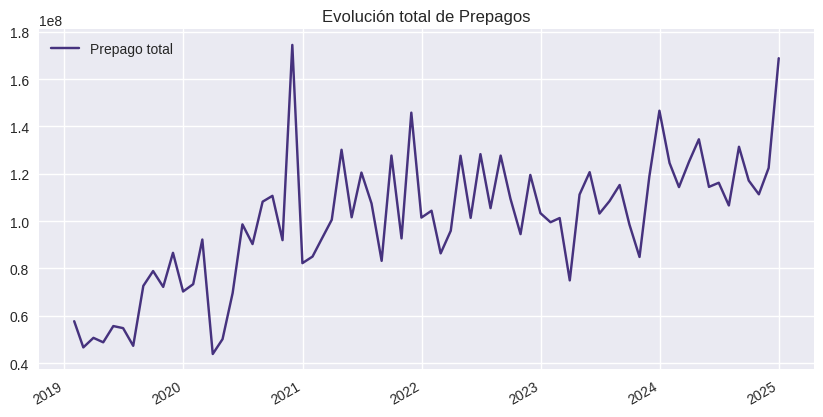

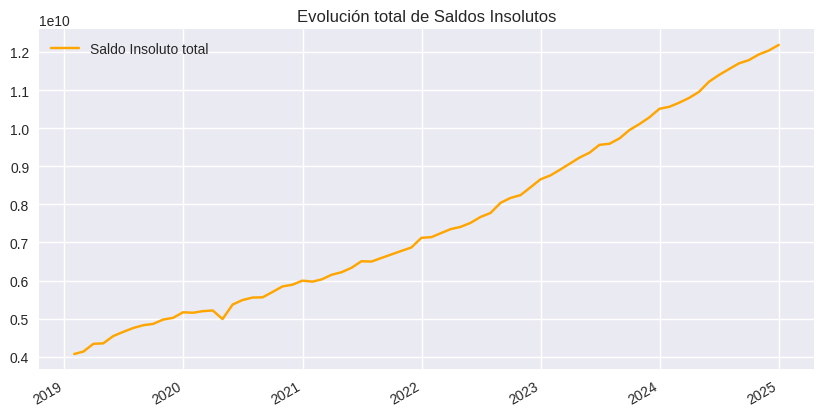

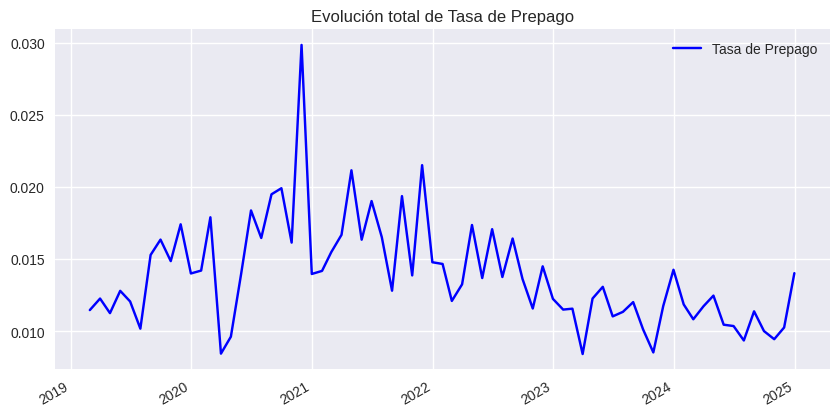

In [111]:
cols = df_saldo.columns
fecha_cols = cols[14:]

prepago_ts = df_prepago[fecha_cols].sum()
saldo_ts = df_saldo[fecha_cols].sum()
tasa_prepago_ts = prepago_ts / saldo_ts.shift(1)

plt.figure(figsize=(10,5))
prepago_ts.plot(label="Prepago total")
plt.title("Evolución total de Prepagos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
saldo_ts.plot(label="Saldo Insoluto total", color="orange")
plt.title("Evolución total de Saldos Insolutos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
tasa_prepago_ts.plot(label="Tasa de Prepago", color="blue")
plt.title("Evolución total de Tasa de Prepago")
plt.legend()
plt.show()

## Algoritmo

Para el modelo baseline del pronóstico de la tasa de prepagos no se considerarán variables exógenas. Se probaran modelos de suavizamiento exponencial dadas las siguientes ventajas:

- Son modelos interpretables y simples
- Permiten considerar patrones estacionales y tendencias

In [112]:
index = pd.date_range("2019-01-31", periods=72, freq="M")
serie = pd.Series(tasa_prepago_ts.values*100, index=index)
serie = serie.dropna()
serie

/tmp/ipython-input-1841893291.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2019-01-31", periods=72, freq="M")


,0
2019-02-28,1.146488
2019-03-31,1.226422
2019-04-30,1.125386
2019-05-31,1.279943
2019-06-30,1.206334
...,...
2024-08-31,1.137825
2024-09-30,1.000886
2024-10-31,0.944625
2024-11-30,1.025859


In [113]:
serie.index.freq

<MonthEnd>

###Holt-Winters

In [114]:
# ajuste de modelo de suavizado exponencial

serie_nov = serie.loc["2019-02-28":"2024-11-30"]
model = ExponentialSmoothing(serie_nov, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated").fit(optimized = True)
pronostico_1_mes = model.forecast(1)

In [115]:
print(f"Pronóstico Dic-24 en {float(pronostico_1_mes.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 0.825232
Dato Real  Dic-24 en 1.402519


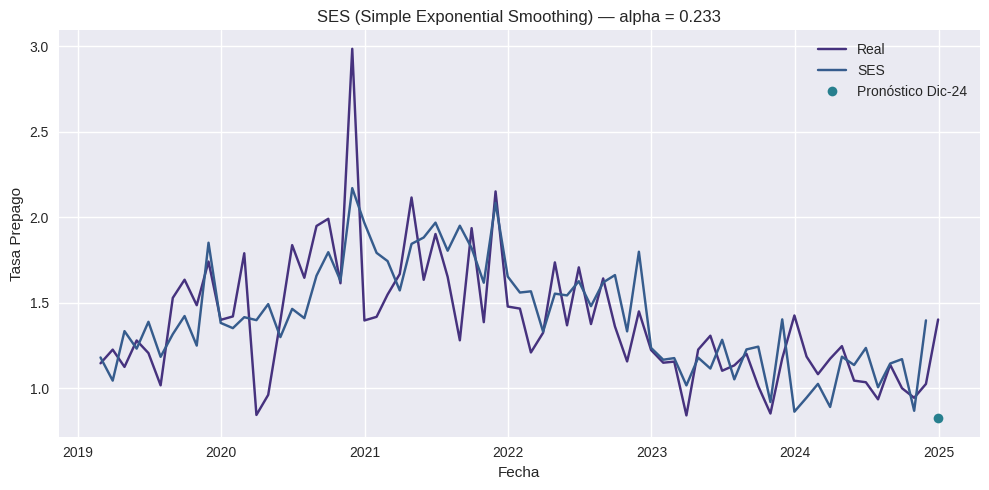

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")
plt.plot(model.fittedvalues, label="SES")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"SES (Simple Exponential Smoothing) — alpha = {alpha:.3f}")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [117]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    fit_bt = ExponentialSmoothing(hist, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated").fit(optimized = True)
    yhat = fit_bt.forecast(1).iloc[0]
    preds.append(yhat)
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses) — SES con alpha optimizado en cada paso")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses) — SES con alpha optimizado en cada paso
MAE : 0.248158
MAPE: 21.7448%


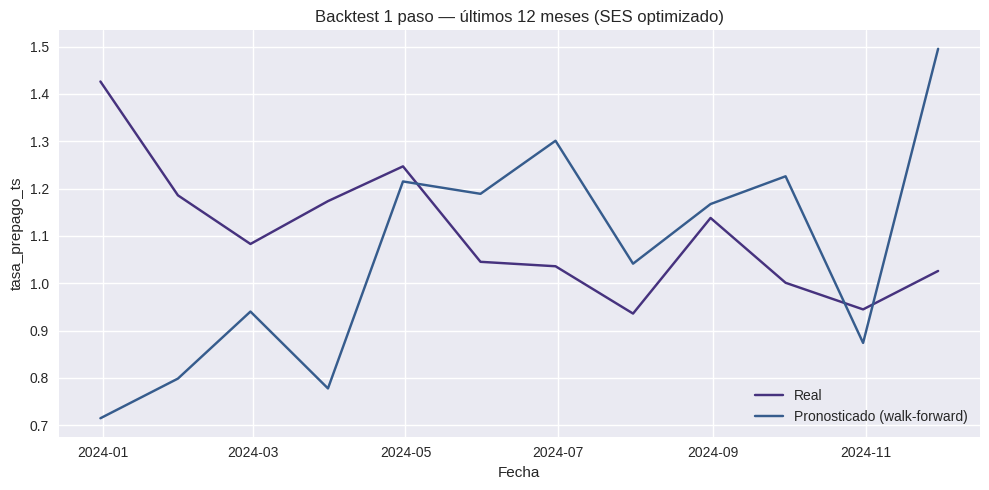

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso — últimos 12 meses (SES optimizado)")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###SES - Suavizamiento Exponencial Simple

Ahora probaremos un modelo de suavizamiento exponencial simple (SES). Este no tiene tendencia ni estacionalidad clara.

In [119]:
# ajuste de modelo de suavizado exponencial

serie_nov = serie.loc["2019-02-28":"2024-11-30"]
model = SimpleExpSmoothing(serie_nov, initialization_method="estimated").fit(optimized = True)
pronostico_1_mes = model.forecast(1)
alpha = model.model.params.get("smoothing_level")

In [120]:
print(f"Pronóstico Dic-24 en {float(pronostico_1_mes.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 1.038161
Dato Real  Dic-24 en 1.402519


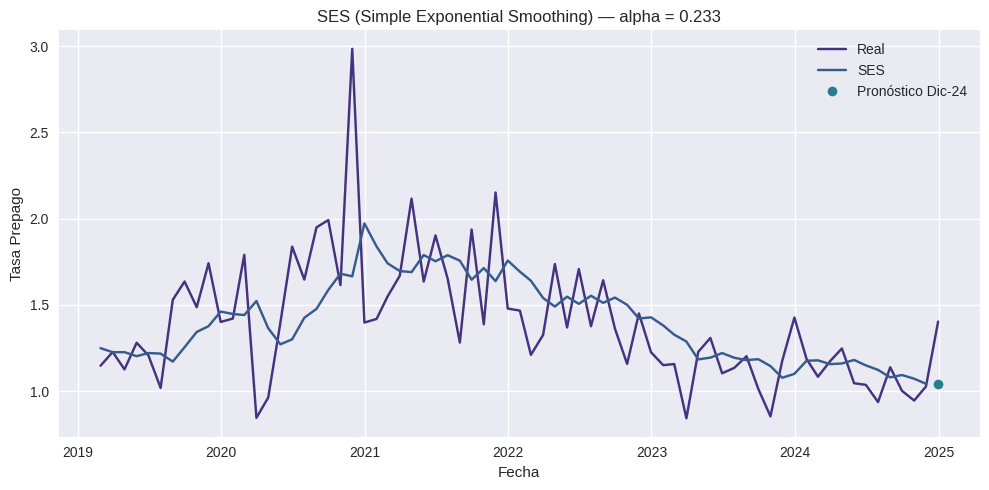

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")
plt.plot(model.fittedvalues, label="SES")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"SES (Simple Exponential Smoothing) — alpha = {alpha:.3f}")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [122]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    fit_bt = SimpleExpSmoothing(hist, initialization_method="estimated").fit(optimized=True)
    yhat = fit_bt.forecast(1).iloc[0]
    preds.append(yhat)
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.105528
MAPE: 9.5232%


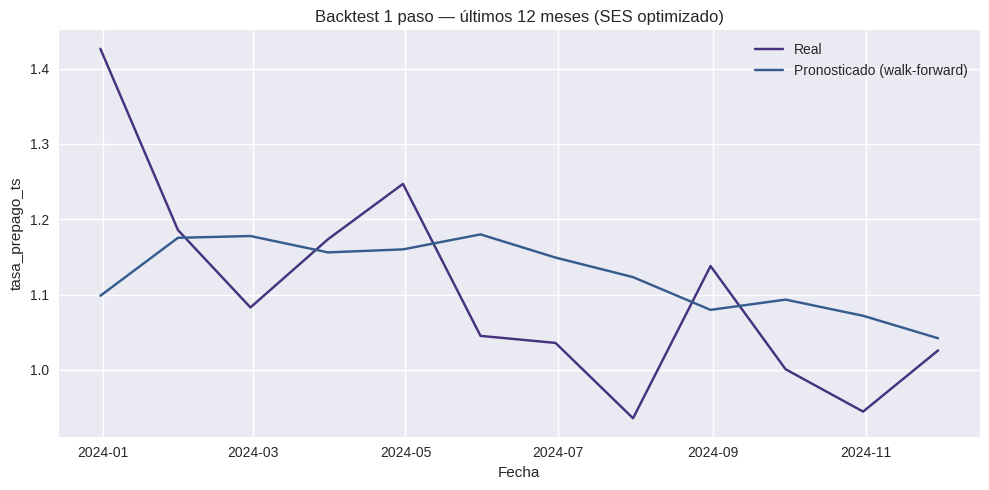

In [123]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso — últimos 12 meses (SES optimizado)")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##Desempeño

Dados los resultados anteriores, para el modelo final se establece un mínimo de:
- MAE: 0.10
- MAPE: 9.5%

Calculados en las pruebas de Backtest de últimos 12 meses.